In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./compression-data.csv', sep=';')

In [3]:
data = data.sort_values('cells')
#data = data[data['cells'] > 0]
data.head()

,cells,bytes,build_duration_nanosec,build_duration_total_nanosec,retr_duration_avg_nanosec,algorithm,table
74,288176,55129640,2335664598,15434106128,217,dedup_hash,main_tokenized_embedding
59,288205,55242576,2457928235,19113037727,215,dedup_hash,main_tokenized
16,288699,54885256,2911245311,21146314556,208,dedup_hash,cocoa_main_tokenized
73,476924,108798048,4464449939,19727347752,228,dedup_hash,main_tokenized_embedding
58,477887,109101472,5155316551,24364439568,228,dedup_hash,main_tokenized


In [ ]:
c = {
    'ns': 'red',
    'baseline': 'blue',
    'dedup_hash': 'orange',
    'dedup_btree': 'violet',
}   


Text(0.5, 1.0, 'access time')

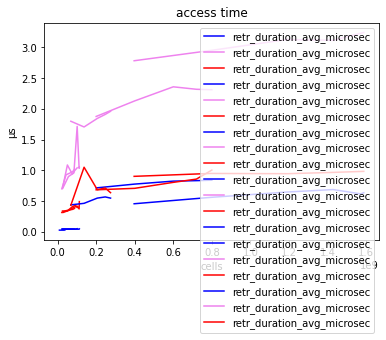

In [26]:
fig, ax = plt.subplots()

data['retr_duration_avg_microsec'] = data['retr_duration_avg_nanosec'] / 1000

data_ = data[data['algorithm'] != 'dedup_hash']
done = set()
for [table,algo], row in data_.groupby(["table", "algorithm"]):
    p, = ax.plot('cells', 'retr_duration_avg_microsec', c=c[algo], data=row)


ax.set_ylabel('μs')
ax.set_xlabel('cells')
ax.set_title("access time")

Ellipsis

<Figure size 432x288 with 0 Axes>

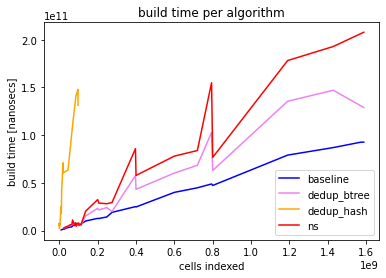

In [5]:
plt.figure(figsize=(6, 4))
fig, bta = plt.subplots()

for algo,row in data.groupby("algorithm"):
    p, = bta.plot('cells', 'build_duration_nanosec', c=c[algo], data=row)
    p.set_label(algo)


bta.set_xlabel('cells indexed')
bta.set_ylabel('build time [nanosecs]')
bta.legend()
bta.set_title("build time per algorithm")

# fig
...

Text(0.5, 1.0, 'memory per table')

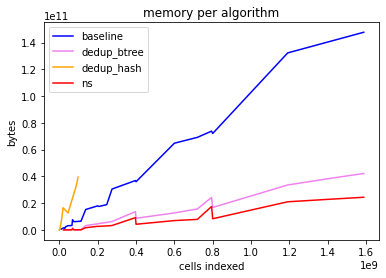

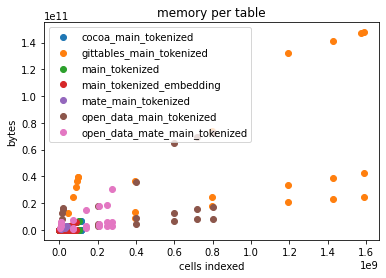

In [6]:
fig,mpa = plt.subplots()
for algo,row in data.groupby("algorithm"):
    p, = mpa.plot('cells', 'bytes', c=c[algo], data=row)
    p.set_label(algo)

mpa.set_xlabel('cells indexed')
mpa.set_ylabel('bytes')
mpa.legend()
mpa.set_title("memory per algorithm")

# now per table
fig,mpt = plt.subplots()
for table,row in data.groupby("table"):
    p = mpt.scatter('cells', 'bytes', data=row)
    p.set_label(table)

mpt.set_xlabel('cells indexed')
mpt.set_ylabel('bytes')
mpt.legend()
mpt.set_title("memory per table")

the memory footprint is not dependant on the dataset at hand, but rather the amount of data consumed and the algorithm presented